In [1]:
# REFERENCE --> https://www.youtube.com/watch?v=pAKwoz05lK4

In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from statsmodels.regression.quantile_regression import QuantReg

import sys
sys.path.append('../scripts/') 

from aux_funcs import label_encoder, load_ct_scans, competition_metric, extract_img_id, get_config, make_ct_git, filter_by_std
from sklearn.model_selection import train_test_split

config = get_config()
train_df = pd.read_csv(config['data_path']+'/train.csv')
test_df = pd.read_csv(config['data_path']+'/test.csv')

In [3]:
def encode_categorical(df):
    sex_encoding = {'Male':0, 'Female':1}
    df.Sex = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['current_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else 0)
    df['ex_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Ex-smoker' else 0)
    df['never_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Never smoked' else 0)
    df.drop(['SmokingStatus'],1,inplace=True)

    return df

def encode_categorical_2(df):
    sex_encoding = {'Male':0, 'Female':1}
    df.Sex = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['SmokingStatus'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else (2 if x == 'Ex-smoker' else 3))

    return df

In [4]:
# Getting the data ready

train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)
patients_train, patients_test = train_test_split(np.unique(train_df['Patient'].values), test_size=0.3, shuffle=True, random_state=63)

df_train = []
for p in patients_train:
    mask = train_df['Patient'] == p
    df_train.append(train_df.values[mask])
df_train = pd.DataFrame(np.concatenate(df_train, 0), columns=list(train_df.columns))

df_test = []
for p in patients_test:
    mask = train_df['Patient'] == p
    df_test.append(train_df.values[mask])
df_test = pd.DataFrame(np.concatenate(df_test, 0), columns=list(train_df.columns))

# Normalizing data
mu_norm = dict()
std_norm = dict()

for feat in ['Weeks', 'FVC', 'Percent', 'Age']:
    mu_norm[feat], std_norm[feat] = np.mean(df_train[feat].values), np.std(df_train[feat].values)
    df_train[feat] = (df_train[feat].values - mu_norm[feat])/std_norm[feat]
    df_test[feat] = (df_test[feat].values - mu_norm[feat])/std_norm[feat]

pats_train = df_train['Patient'].values
pats_test = df_test['Patient'].values

X_train = df_train.drop(['Patient', 'FVC'], 1)
cols_X = X_train.columns
X_train = X_train.values.astype(np.float32)
Y_train = df_train['FVC'].values.astype(np.float32)
X_test = df_test.drop(['Patient', 'FVC'], 1).values.astype(np.float32)
Y_test = df_test['FVC'].values.astype(np.float32)

In [5]:
cols_X

Index([&#39;Weeks&#39;, &#39;Percent&#39;, &#39;Age&#39;, &#39;Sex&#39;, &#39;current_smoker&#39;, &#39;ex_smoker&#39;,
       &#39;never_smoker&#39;],
      dtype=&#39;object&#39;)

In [7]:
class QuantileRegressor:
    def __init__(self, qs=[0.05, 0.5, 0.95]):
        self.quantiles = qs
    def fit(self, X, Y):
        qr = QuantReg(Y_train, X_train)
        coeffs = []
        history = []
        for q in self.quantiles:
            res = qr.fit(q=q, max_iter=int(1e3))
            coeffs.append(res.params)
            history.append(res.history)
        self.coeffs_ = np.stack(coeffs, 0)
        self.history_ = history
    
    def predict(self, X):
        return np.dot(X,self.coeffs_.T)
    
    def predict_competition(self, X):
        preds = self.predict(X)
        #return preds[:,1] , (preds[:,0]+preds[:,2])/2
        return np.mean(preds,1) , 280

In [8]:
#QR = QuantileRegressor(qs=[0.25, 0.5, 0.75])
QR = QuantileRegressor(qs=[0.25, 0.50, 0.75])
QR.fit(X_train, Y_train)

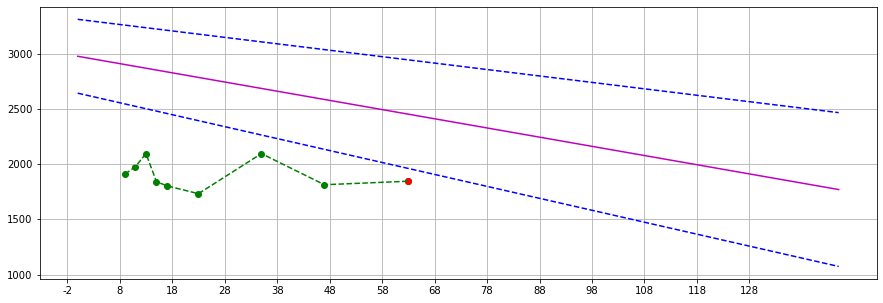

Competition metric -9.894083


In [9]:
id_pat = np.random.randint(X_test.shape[0])
X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_test[id_pat:id_pat+1, 1:], 146, axis=0)])
q_pred = QR.predict(X_pred)
# https://stats.stackexchange.com/questions/256456/how-to-calculate-mean-and-sd-from-quartiles
Y_pred = np.mean(q_pred, 1)
sigma_pred_low = Y_pred - (q_pred[:,2] - q_pred[:,0])/1.35
sigma_pred_up = Y_pred + (q_pred[:,2] - q_pred[:,0])/1.35

mask = df_test['Patient'] == pats_test[id_pat]
test_vals = df_test[['Patient', 'Weeks', 'FVC']].values[mask,1:]

plt.figure(figsize=(15,5))
plt.plot(Y_pred*std_norm['FVC']+mu_norm['FVC'], linestyle='-', c='m')
#plt.plot(Y_pred*std_norm['FVC']+mu_norm['FVC'] + sigma_pred*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='b')
plt.plot(sigma_pred_low*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='b')
plt.plot(sigma_pred_up*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='b')
#plt.plot(Y_pred*std_norm['FVC']+mu_norm['FVC']-sigma_pred*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='b')

#plt.figure(figsize=(15,5))
#plt.plot(q_pred[:,0]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='b')
#plt.plot(q_pred[:,1]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='m')
#plt.plot(q_pred[:,2]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='b')

plt.xticks(range(-12,134, 10), range(-12,134, 10))
plt.scatter(test_vals[:,0]*std_norm['Weeks']+mu_norm['Weeks'], test_vals[:,1]*std_norm['FVC']+mu_norm['FVC'], c='g')
plt.plot(test_vals[:,0]*std_norm['Weeks']+mu_norm['Weeks'], test_vals[:,1]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='g')
plt.grid()
plt.scatter(X_test[id_pat:id_pat+1, 0]*std_norm['Weeks']+mu_norm['Weeks'], Y_test[id_pat:id_pat+1]*std_norm['FVC']+mu_norm['FVC'], c='r')
plt.show()

q_pred = QR.predict(X_test)
Y_pred_comp = np.mean(q_pred, 1)*std_norm['Weeks']+mu_norm['Weeks']
sigma_pred_comp = np.abs((Y_pred_comp - (q_pred[:,2] - q_pred[:,0])/1.35)*std_norm['Weeks']+mu_norm['Weeks'])
Y_true = (Y_test*std_norm['FVC'])+mu_norm['FVC']

print('Competition metric', np.mean(competition_metric(Y_true, Y_pred_comp, sigma_pred_comp )))

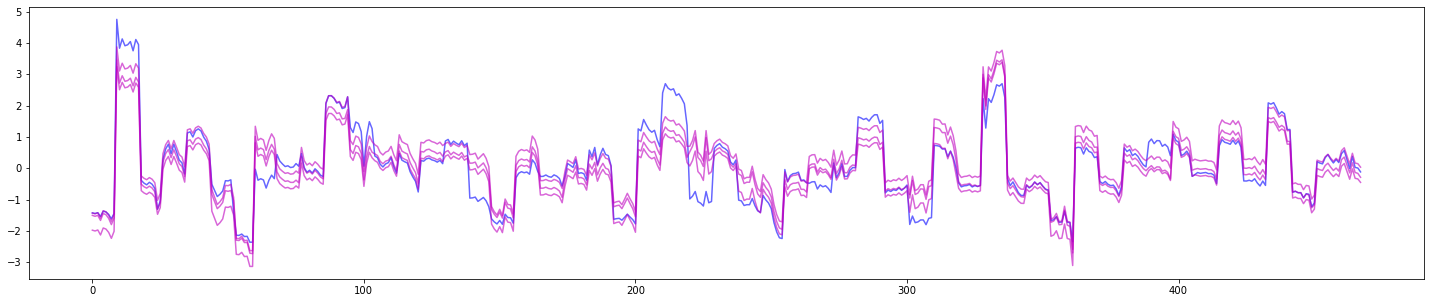

In [10]:
plt.figure(figsize=(25,5))
plt.plot(Y_test, c='b', alpha=0.6)
plt.plot(QR.predict(X_test), c='m', alpha=0.6)
plt.show()

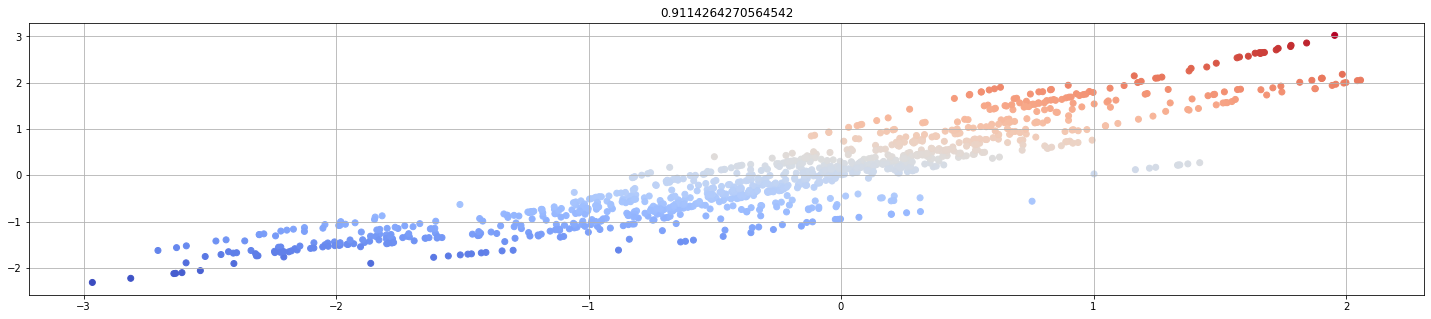

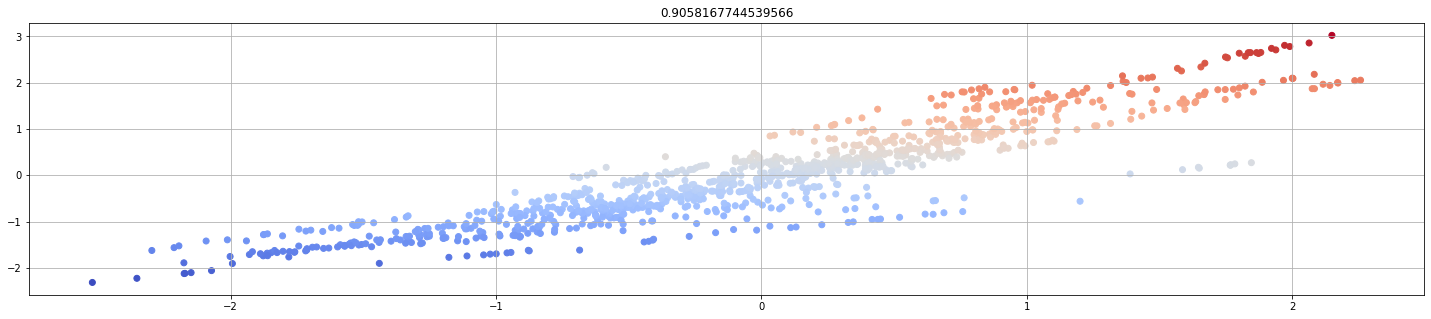

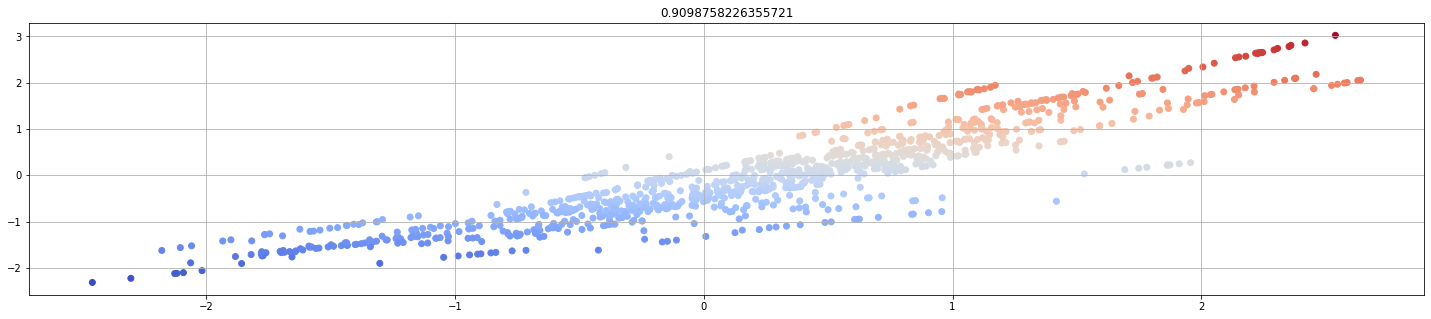

In [11]:
qreg = QR.predict(X_train)

for i in range(qreg.shape[1]):
    plt.figure(figsize=(25,5))
    plt.title(np.abs(np.corrcoef(Y_train, qreg[:,i])[0][1]))
    plt.scatter(qreg[:,i], Y_train, cmap='coolwarm', c=Y_train)
    plt.grid()
    plt.show()

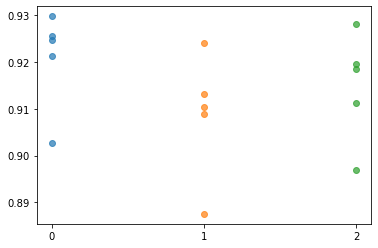

In [12]:
# https://towardsdatascience.com/best-exponential-transformation-to-linearize-your-data-with-scipy-cca6110313a6
from scipy.optimize import minimize_scalar
from functools import partial
from sklearn.model_selection import KFold


class LinearizeQuant:
    def __init__(self, val_min):
        self.val_min_ = val_min
        self.opt_e = dict()

    def target_foo(self, e, X, Y):
        r = np.corrcoef(Y,X**e)
        return -abs(r[0][1])

    def fit(self, X, Y):
        for idx in range(X.shape[1]):
            res = minimize_scalar(partial(self.target_foo, X=X[:,idx]-self.val_min_, Y=Y))
            if not res.success:
                print('Error optimizing linearization of quantile', idx)
            self.opt_e[idx] = res.x

    def transform(self, X):
        Xvals = (X-self.val_min_).copy()
        for idx in range(Xvals.shape[1]):
            Xvals[:,idx] = Xvals[:,idx]**self.opt_e[idx]
        return Xvals


cv_results = []
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)
LQ = LinearizeQuant(val_min=-3.4)

for train_index, test_index in cv_folds.split(X_train):
    X_lin_train, Y_lin_train = X_train[train_index], Y_train[train_index]
    X_lin_test,  Y_lin_test  = X_train[test_index],  Y_train[test_index]

    fold_results = []
    qreg = QR.predict(X_lin_train)
    LQ.fit(qreg, Y_lin_train)
    qreg = LQ.transform(QR.predict(X_lin_test))
    for i in range(qreg.shape[1]):
        fold_results.append(np.corrcoef(Y_lin_test,qreg[:,i])[0][1])

    cv_results.append(np.array(fold_results))


cv_results = np.stack(cv_results, 0)
for i in range(cv_results.shape[1]):
    plt.scatter(np.ones_like(cv_results[:,0])*i, cv_results[:,i], alpha=0.7)
plt.xticks(np.arange(cv_results.shape[1]), np.arange(cv_results.shape[1]))
plt.show()

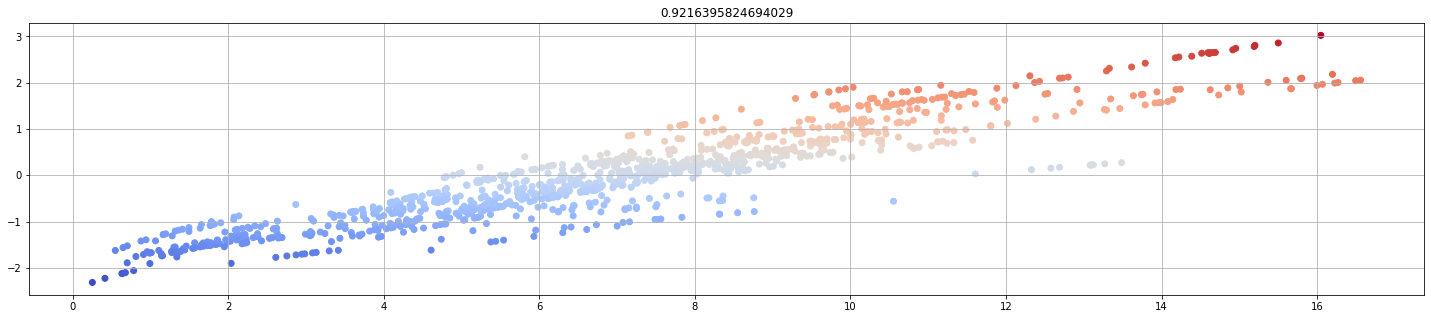

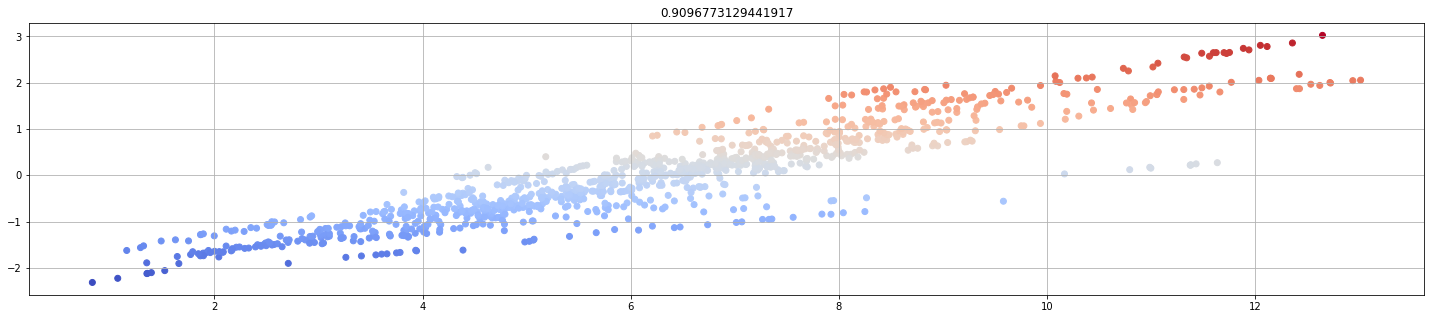

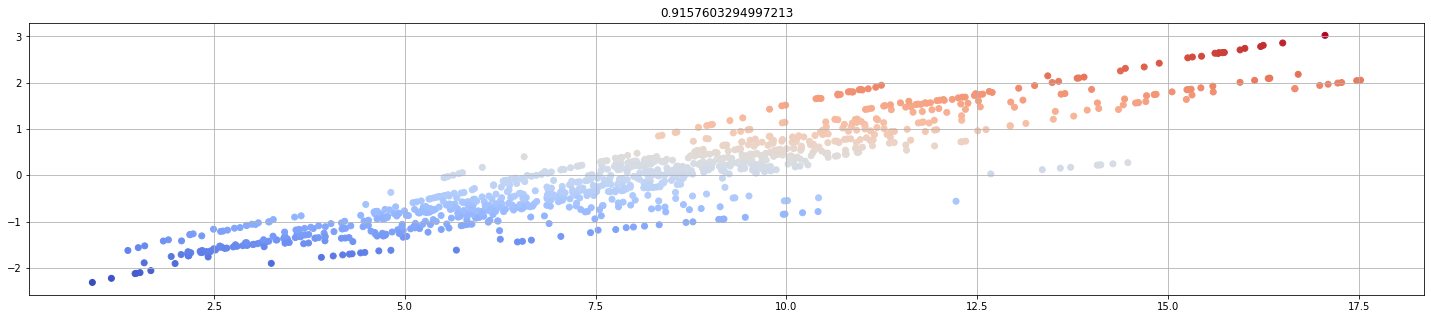

In [13]:
LQ = LinearizeQuant(val_min=-3.4)

LQ.fit(QR.predict(X_train), Y_train)
qreg = LQ.transform(QR.predict(X_train))

for i in range(qreg.shape[1]):
    plt.figure(figsize=(25,5))
    plt.title(np.abs(np.corrcoef(Y_train, qreg[:,i])[0][1]))
    plt.scatter(qreg[:,i], Y_train, cmap='coolwarm', c=Y_train)
    plt.grid()
    plt.show()

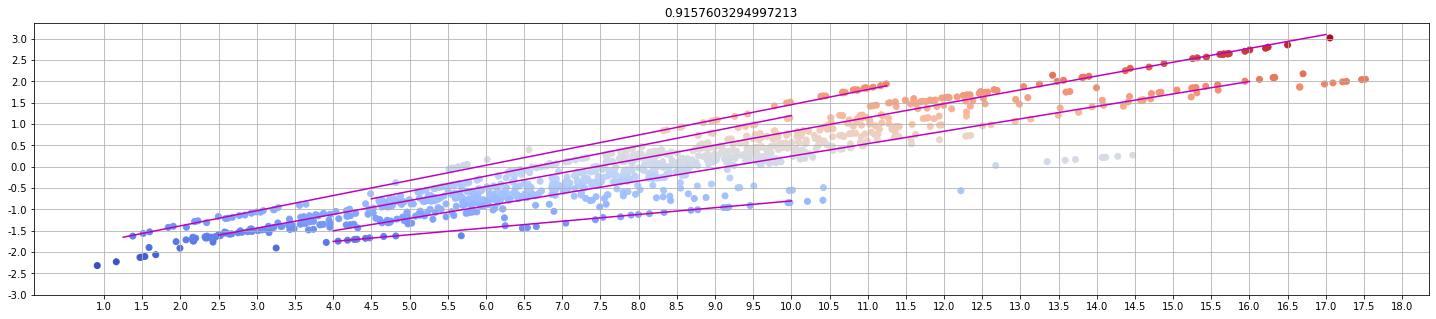

In [14]:
# Try to cluster the lines

LQ = LinearizeQuant(val_min=-3.4)

LQ.fit(QR.predict(X_train), Y_train)
qreg = LQ.transform(QR.predict(X_train))

line0 = np.array([[1.25, 11.25, -1.65, 1.9]]).reshape(1,-1)
line1 = np.array([[4.5, 10, -0.75, 1.2]]).reshape(1,-1)
line2 = np.array([[2.5, 17,-1.6, 3.1]]).reshape(1,-1)
line3 = np.array([[4, 16,-1.5, 2.0]]).reshape(1,-1)
line4 = np.array([[4, 10,-1.75, -0.8]]).reshape(1,-1)

lines = np.concatenate([line0, line1, line2, line3, line4], 0)

plt.figure(figsize=(25,5))
plt.title(np.abs(np.corrcoef(Y_train, qreg[:,2])[0][1]))
plt.scatter(qreg[:,2], Y_train, cmap='coolwarm', c=Y_train)
for i in range(lines.shape[0]):
    plt.plot(lines[i,:2], lines[i,2:], c='m')
plt.grid()
plt.xticks(np.arange(1,18.5,0.5), np.arange(1,18.5,0.5))
plt.yticks(np.arange(-3,3.5,0.5), np.arange(-3,3.5,0.5))
plt.show()

In [15]:
def get_line(p):
    m = (p[3]-p[2])/(p[1]-p[0])
    n = p[3] - m*p[1]
    return m,n

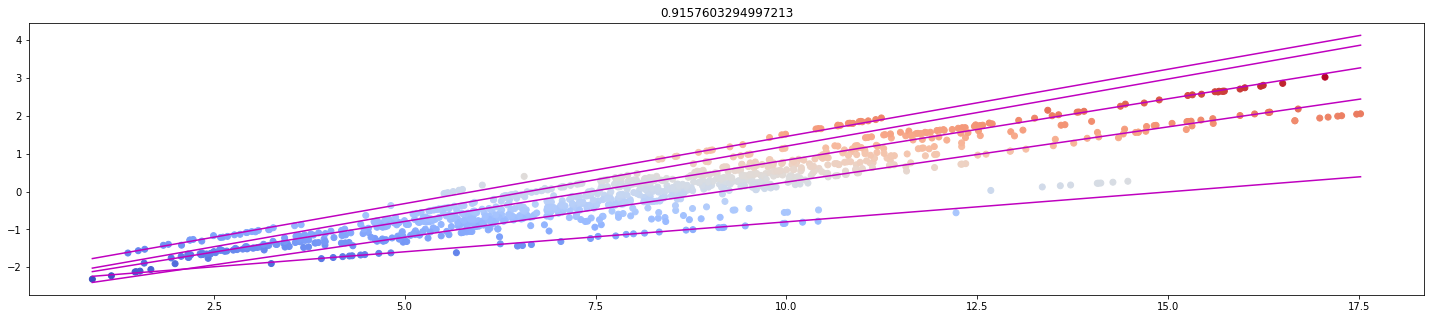

In [18]:
x_axis = np.sort(np.unique(qreg[:,2]))
plt.figure(figsize=(25,5))
plt.title(np.abs(np.corrcoef(Y_train, qreg[:,2])[0][1]))
plt.scatter(qreg[:,2], Y_train, cmap='coolwarm', c=Y_train)
for i in range(lines.shape[0]):
    m,n = get_line(lines[i])
    plt.plot(x_axis, m*x_axis+n, c='m')
plt.show()

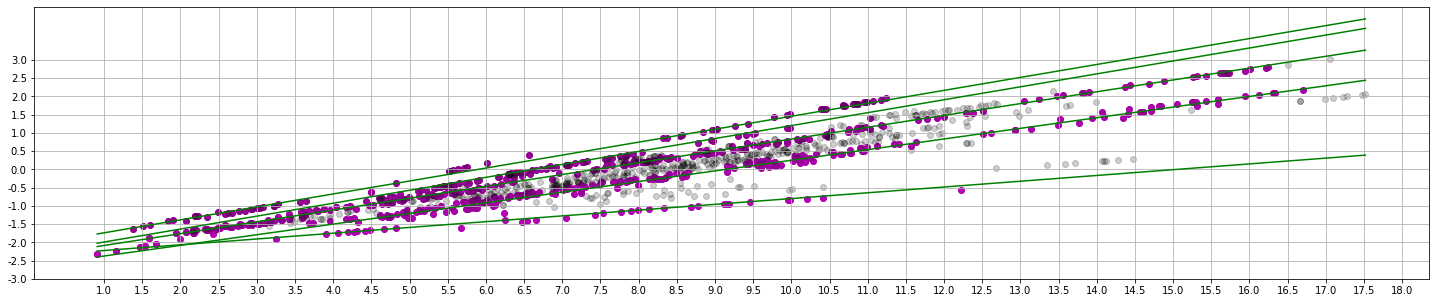

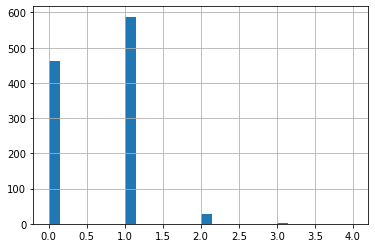

In [42]:
masks = []
qs = [0.06, 0.1, 0.2, 0.2, 0.04]
plt.figure(figsize=(25,5))
for i in range(lines.shape[0]):
    m,n = get_line(lines[i])

    dist = []
    line_point = m*x_axis+n
    for p in list(zip(qreg[:,2], Y_train)):
        dist.append((p[1]-m*p[0]-n)**2)
    dist = np.array(dist)

    mask = dist<np.quantile(dist,qs[i])
    masks.append(mask)
    
    plt.scatter(qreg[mask,2], Y_train[mask], c='m')
    plt.plot(x_axis, m*x_axis+n, c='g')
    plt.scatter(qreg[:,2], Y_train, c='k', alpha=0.2/5)
    plt.grid()
    plt.xticks(np.arange(1,18.5,0.5), np.arange(1,18.5,0.5))
    plt.yticks(np.arange(-3,3.5,0.5), np.arange(-3,3.5,0.5))
plt.show()
masks = np.stack(masks, 0)

plt.hist(masks.sum(0), bins=np.arange(0,5,1), width=0.15, align='mid')
plt.grid()
plt.show()

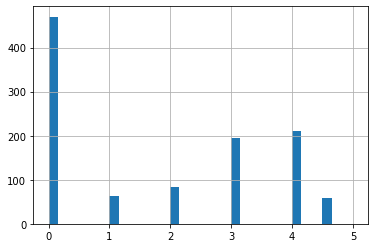

In [54]:
labels = np.zeros((masks.shape[1],))
for i in range(masks.shape[0]):
    labels += masks[i]*(i+1)
labels[labels>5] = 0

plt.hist(labels, width=0.15)
plt.grid()
plt.show()

100%|██████████| 9/9 [00:14&lt;00:00,  1.64s/it]


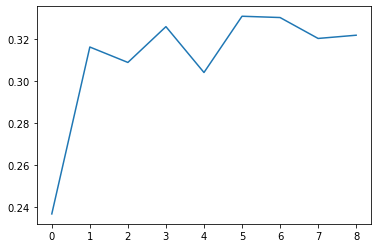

In [151]:
X_clf = X_train_svr[labels!=0]
Y_clf = labels[labels!=0]

from sklearn.ensemble import RandomForestClassifier

cv_folds = KFold(n_splits=3)
cv_f1_scores = []

for est in tqdm([2**i for i in range(1,10)]):

    est_score = []
    for train_index, test_index in cv_folds.split(X_clf):
        X_cv_train, Y_cv_train = X_clf[train_index], Y_clf[train_index]
        X_cv_test,  Y_cv_test  = X_clf[test_index],  Y_clf[test_index]

        clf = RandomForestClassifier(n_estimators=est, n_jobs=-1, class_weight='balanced_subsample')
        clf.fit(X_cv_train, Y_cv_train)

        f1_val = f1_score(Y_cv_test, clf.predict(X_cv_test), average='weighted')
        est_score.append(f1_val)

    cv_f1_scores.append(np.mean(est_score))

plt.plot(cv_f1_scores)
plt.show()

In [152]:
f1_score(Y_clf_test, clf.predict(X_clf_test), average='weighted')

0.7334006514756866

In [153]:
from sklearn.metrics import classification_report
print(classification_report(Y_clf_test, clf.predict(X_clf_test)))

              precision    recall  f1-score   support

         1.0       0.57      0.42      0.48        19
         2.0       0.79      0.60      0.68        25
         3.0       0.72      0.80      0.76        59
         4.0       0.77      0.84      0.80        63
         5.0       0.76      0.72      0.74        18

    accuracy                           0.74       184
   macro avg       0.72      0.68      0.69       184
weighted avg       0.74      0.74      0.73       184



In [57]:
from sklearn.svm import SVR

LQ = LinearizeQuant(val_min=-10)
LQ.fit(QR.predict(X_train), Y_train)

X_train_svr = np.hstack([X_train, LQ.transform(QR.predict(X_train))])
X_test_svr = np.hstack([X_test, LQ.transform(QR.predict(X_test))])


cv_vals = np.linspace(1e-4, 1.0, 10)
kernels_vals = ['rbf', 'poly']
degree_vals = np.arange(1,3,1)
configs = np.array(np.meshgrid(cv_vals, kernels_vals, degree_vals)).T.reshape(-1,3)
cv_folds = KFold(n_splits=5)

cv_params_results = dict()
for i, config in tqdm(enumerate(configs), total=configs.shape[0]):
    cv_results = []
    for train_index, test_index in cv_folds.split(X_train):
        X_cv_train, Y_cv_train = X_train_svr[train_index], Y_train[train_index]
        X_cv_test,  Y_cv_test  = X_train_svr[test_index],  Y_train[test_index]

        machine = SVR(C=float(config[0]), kernel=str(config[1]), degree=int(config[2]))
        machine.fit(X_cv_train, Y_cv_train)
        cv_results.append(np.mean(np.square(Y_cv_test-machine.predict(X_cv_test))))

    cv_params_results[i] = np.mean(cv_results)

idx_opt_config = list(cv_params_results.keys())[np.argmin(list(cv_params_results.values()))]
opt_config = configs[idx_opt_config]

machine = SVR(C=float(opt_config[0]), kernel=str(opt_config[1]), degree=int(opt_config[2]))
machine.fit(X_train_svr, Y_train)

100%|██████████| 40/40 [00:03&lt;00:00, 10.12it/s]


SVR(C=0.33340000000000003, degree=1)

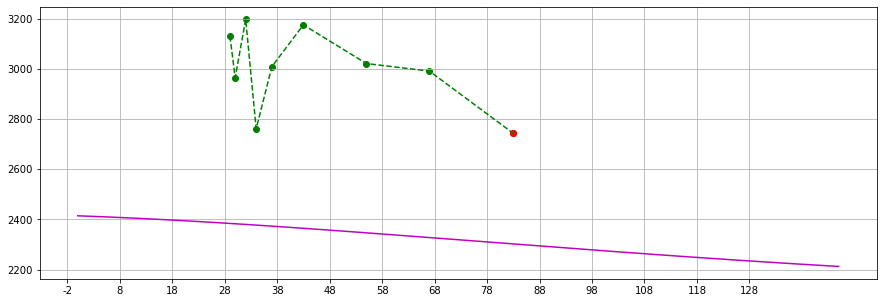

In [45]:
id_pat = np.random.randint(X_test.shape[0])
X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_test[id_pat:id_pat+1, 1:], 146, axis=0)])
X_pred_svr = np.hstack([X_pred, LQ.transform(QR.predict(X_pred))])
Y_pred = machine.predict(X_pred_svr)

mask = df_test['Patient'] == pats_test[id_pat]
test_vals = df_test[['Patient', 'Weeks', 'FVC']].values[mask,1:]

plt.figure(figsize=(15,5))
plt.plot(Y_pred*std_norm['FVC']+mu_norm['FVC'], linestyle='-', c='m')
plt.xticks(range(-12,134, 10), range(-12,134, 10))
plt.scatter(test_vals[:,0]*std_norm['Weeks']+mu_norm['Weeks'], test_vals[:,1]*std_norm['FVC']+mu_norm['FVC'], c='g')
plt.plot(test_vals[:,0]*std_norm['Weeks']+mu_norm['Weeks'], test_vals[:,1]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='g')
plt.grid()
plt.scatter(X_test[id_pat:id_pat+1, 0]*std_norm['Weeks']+mu_norm['Weeks'], Y_test[id_pat:id_pat+1]*std_norm['FVC']+mu_norm['FVC'], c='r')
plt.show()

In [ ]:
'''id_pat = np.random.randint(X_test.shape[0])
X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_test[id_pat:id_pat+1, 1:], 146, axis=0)])
q_pred = QR.predict(X_pred)

mask = df_test['Patient'] == pats_test[id_pat]
test_vals = df_test[['Patient', 'Weeks', 'FVC']].values[mask,1:]

plt.figure(figsize=(15,5))
plt.plot(q_pred[:,0]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='b')
plt.plot(q_pred[:,1]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='m')
plt.plot(q_pred[:,2]*std_norm['FVC']+mu_norm['FVC'], linestyle='--', c='k')

plt.xticks(range(-12,134, 10), range(-12,134, 10))
plt.scatter((test_vals[:,0]*std_norm['Weeks'])+mu_norm['Weeks'], (test_vals[:,1]*std_norm['FVC'])+mu_norm['FVC'], c='g')
plt.plot((test_vals[:,0]*std_norm['Weeks'])+mu_norm['Weeks'], (test_vals[:,1]*std_norm['FVC'])+mu_norm['FVC'], linestyle='--', c='g')

plt.scatter((X_test[id_pat:id_pat+1, 0]*std_norm['Weeks'])+mu_norm['Weeks'], (Y_test[id_pat:id_pat+1]*std_norm['FVC'])+mu_norm['FVC'], c='r')
plt.show()

Y_pred_comp, sigma_pred_comp = QR.predict_competition(X_test)
Y_pred_comp = Y_pred_comp *std_norm['FVC']+mu_norm['FVC']
sigma_pred_comp = sigma_pred_comp *std_norm['FVC']+mu_norm['FVC']
Y_true = (Y_test*std_norm['FVC'])+mu_norm['FVC']

print('Competition metric', np.mean(competition_metric(Y_true, Y_pred_comp, sigma_pred_comp )))'''

In [ ]:
# Generate competition submission

submission = []

for i in range(test_df.shape[0]):
    patient = test_df.values[i,0]
    X_pred = test_df[cols_X].iloc[i:i+1,:]

    for feat in ['Weeks', 'Percent', 'Age']:
        X_pred[feat] = (X_pred[feat].values - mu_norm[feat])/std_norm[feat]
    X_pred = X_pred.values.reshape(1,-1)

    X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X_pred[:, 1:], 146, axis=0)])
    Y_pred = (lin_reg.predict(X_pred)*std_norm['FVC'])+mu_norm['FVC']

    patient_submission = []
    for j, w in enumerate(np.arange(-12,134)):
        vals = np.array([w, patient+'_'+str(w), Y_pred[j], (std_linreg*std_norm['FVC'])+mu_norm['FVC']]).reshape(1,-1)
        vals = pd.DataFrame(vals, columns=['Week', 'Patient_Week', 'FVC', 'Confidence'])
        vals['Week'] = vals['Week'].astype(np.int32)
        vals['FVC'] = vals['FVC'].astype(np.float32)
        vals['Confidence'] = vals['Confidence'].astype(np.float32)
        patient_submission.append(vals)
    patient_submission = pd.concat(patient_submission)
    submission.append(patient_submission)

submission = pd.concat(submission)
submission.sort_values('Week', inplace=True)
submission.drop(['Week'], 1, inplace=True)

submission.head()
submission.to_csv('submission.csv', index=False)